In [103]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from numpy import mean
from sklearn import svm as svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot


from sklearn.metrics import r2_score, roc_auc_score, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

from sklearn.utils import resample
random.seed(123)

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', 500)

In [104]:
# dataset import
df = pd.read_csv("Dataset_Scaled.csv", low_memory=False)

# dataset shape
print("Sample Size:", df.shape[0])
print("# of predictors:", df.shape[1])

Sample Size: 22992
# of predictors: 96


In [105]:
# required variables, features, and label

req_vars = ['SwellOneExit', 'YearsAsCoach', 'DaysTSubmitNoMissing',
       'FitNoMissing', 'RelationshipBuildingNoMissing',
       'FinalAchievementNoMissing', 'CommAndPresNoMissing',
       'PredModelScoreNoMissing', 'CMProspectRatingNoMissing',
       'AgeAtFDOSNoMissing', 'SchoolSelectivityNoMissing',
       'CumuGPANoMissing', 'PerseveranceNoMissing', 'FRPLNoMissing',
       'YearsSchoolPartnerNoMissing', 'YearsPartnerPartnerNoMissing',
       'FirstYearsInSchoolNoMissing', 'SecondYearsInSchoolNoMissing',
       'CMsInSchoolNoMissing', 'CertProgramCostNoMissing',
       'AvgFirstMonthSalNoMissing', 'RentPropNoMissing',
       'AvgRentNoMissing', 'CorpsSizeNoMissing', 'RegPrefLevNoMissing',
       'CSI6NoMissing', 'CSI5NoMissing', 'CSI3NoMissing',
       'CSI12NoMissing', 'CLI8NoMissing', 'CLI6NoMissing',
       'OtherCMsSameCoachNoMissing', 'OtherCMsPrevCoachNoMissing',
       'K12TeachNo', 'K12TeachYes', 'K12TeachNull', 'HadFamRespNo',
       'HadFamRespYes', 'HadFamRespNull', 'PellGrantNoOrMissing',
       'PellGrantYes', 'GenderFemale', 'GenderMale', 'CalcGradStudent',
       'CalcJunior', 'CalcProfessional', 'CalcUndergrad', 'CalcUnknown',
       'AttendLIC_HS_No', 'AttendLIC_HS_Yes', 'AttendLIC_HS_Unknown',
       'GrewUpLIC_No_Or_Unknown', 'GrewUpLIC_Yes',
       'LIC_Served_No_Or_Unknown', 'LIC_Served_Yes', 'Eth_Black',
       'Eth_Native', 'Eth_AsianAmPacIsl', 'Eth_Latinx',
       'Eth_MultiEthMultiRacial', 'Eth_OtherOrUnknown', 'Eth_White',
       'VarsitySport_No_Or_Unknown', 'VarsitySport_Yes',
       'DeferralRequested', 'DeferralNotRequested', 'Title1No',
       'Title1Yes', 'Grade_ECE', 'Grade_HIGH', 'Grade_LOWELEM',
       'Grade_MIDDLE', 'Grade_UPPERELEM', 'Grade_Unknown',
       'School_Charter', 'School_Public', 'School_Other', 'LGB_NoProtect',
       'LGB_LocalProtect', 'LGB_StateProtect', 'TeacherPP_No',
       'TeacherPP_Yes', 'Region_Large', 'Region_Medium', 'Region_Small',
       'Urbanicity_Both', 'Urbanicity_Rural', 'Urbanicity_Urban',
       'COL_High', 'COL_Low', 'COL_Medium', 'MajorTeaching_Match',
       'MajorTeaching_Mismatch', 'MajorOffered_Match',
       'MajorOffered_Mismatch']

df = df[req_vars] # updating the dataframe with only required variables

Y = df['SwellOneExit'] # label
X = pd.DataFrame(df.drop(['SwellOneExit', 'FirstYearsInSchoolNoMissing', 'SecondYearsInSchoolNoMissing'], axis=1)) # dropping first years and second years because of multicollinearity


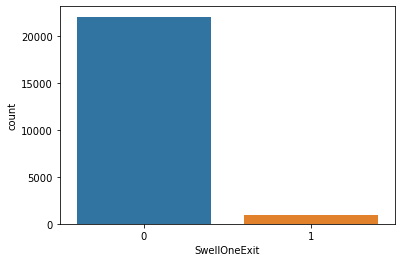

In [106]:
# correlation matrix
pd.DataFrame(df.corr()).to_csv("Correlation_Matrix_Scaled_DF.csv")

# bar graph to show to distribution of the label we are interested in
y = df['SwellOneExit']
hst = sns.countplot(x = y, data = df) # because the dataset is imbalanced, we will build models with both oversampling and undersampling techniques

In [107]:
# training test split

train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size = 0.2, random_state=123)

In [108]:
## -- OVERSAMPLING -- ##

# Oversampling the minority class 
df_ovsmpl = pd.concat([train_features, train_labels], axis=1)


df_majority = df_ovsmpl[df_ovsmpl.SwellOneExit==0]
df_minority = df_ovsmpl[df_ovsmpl.SwellOneExit==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # oversampling with replacement
                                 n_samples=len(df_majority),    # to match majority class size
                                 random_state=123) # for reproducible results
 
# combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled]) # final dataframe with oversampled minority class
 
# display new class counts
df_upsampled.SwellOneExit.value_counts()

1    17662
0    17662
Name: SwellOneExit, dtype: int64

In [109]:
# modeling with oversampled dataframe

upsmpl_Y = df_upsampled['SwellOneExit'] # label
upsmpl_X = df_upsampled.drop('SwellOneExit', axis=1) # features

# training test split of the oversampled dataframe
upsmpl_train_features, upsmpl_test_features, upsmpl_train_labels, upsmpl_test_labels = train_test_split(upsmpl_X, upsmpl_Y, test_size = 0.2, random_state=123)


In [110]:
# Oversampled Modeling: Random Forest

rf_upsampled = RandomForestClassifier(n_estimators = 1000, random_state=0, n_jobs=-1)

# train model
rf_upsampled_mdl = rf_upsampled.fit(upsmpl_train_features, upsmpl_train_labels)

# test model
rf_upsampled_pred = rf_upsampled_mdl.predict(test_features) # testing on the test features from the original dataframe


# performance matrix
rf_upsmpl_matrix = pd.DataFrame(data=[accuracy_score(test_labels, rf_upsampled_pred), recall_score(test_labels, rf_upsampled_pred), precision_score(test_labels, rf_upsampled_pred), f1_score(test_labels, rf_upsampled_pred), roc_auc_score(test_labels, rf_upsampled_pred), confusion_matrix(test_labels, rf_upsampled_pred)],
                                index=["accuracy", "recall", "precision", "f1_score", "roc_auc_score", "confusion_matrix"],
                                columns=['RF_Umsampled_Score'])

rf_upsmpl_matrix

,RF_Umsampled_Score
accuracy,0.963905
recall,0
precision,0
f1_score,0
roc_auc_score,0.499887
confusion_matrix,"[[4433, 1], [165, 0]]"


In [111]:
# XGBoost

ratio_neg_pos = (len(test_labels) - test_labels.sum()) / test_labels.sum() # ratio of majority to minority class
xgb_mdl = xgb.XGBClassifier(scale_pos_weight = ratio_neg_pos).fit(train_features, train_labels) # xgboost adjusts for the imbalanced dataset

xgb_mdl_pred = xgb_mdl.predict(test_features) # test model

# performance matrix
xgb_matrix = pd.DataFrame(data=[accuracy_score(test_labels, xgb_mdl_pred), recall_score(test_labels, xgb_mdl_pred), precision_score(test_labels, xgb_mdl_pred), f1_score(test_labels, xgb_mdl_pred), roc_auc_score(test_labels, xgb_mdl_pred), confusion_matrix(test_labels, xgb_mdl_pred)],
                                index=["accuracy", "recall", "precision", "f1_score", "roc_auc_score", "confusion_matrix"],
                                columns=['XGB_Score'])

xgb_matrix

,XGB_Score
accuracy,0.680583
recall,0.460606
precision,0.0521978
f1_score,0.0937693
roc_auc_score,0.574687
confusion_matrix,"[[3054, 1380], [89, 76]]"


In [112]:
# XGBoost with Oversampled Dataframe

# ratio_neg_pos = (len(test_labels) - test_labels.sum()) / test_labels.sum() # ratio of majority to minority class
xgb_upsmpl_mdl = xgb.XGBClassifier().fit(upsmpl_train_features, upsmpl_train_labels)

# test model
xgb_upsmpl_mdl_pred = xgb_upsmpl_mdl.predict(test_features)

# Performance Matrix
xgb_upsmpl_matrix = pd.DataFrame(data=[accuracy_score(test_labels, xgb_upsmpl_mdl_pred), recall_score(test_labels, xgb_upsmpl_mdl_pred), precision_score(test_labels, xgb_upsmpl_mdl_pred), f1_score(test_labels, xgb_upsmpl_mdl_pred), roc_auc_score(test_labels, xgb_upsmpl_mdl_pred), confusion_matrix(test_labels, xgb_upsmpl_mdl_pred)],
                                index=["accuracy", "recall", "precision", "f1_score", "roc_auc_score", "confusion_matrix"],
                                columns=['XGB_Upsampled_Score'])

xgb_upsmpl_matrix

,XGB_Upsampled_Score
accuracy,0.757339
recall,0.436364
precision,0.0657534
f1_score,0.114286
roc_auc_score,0.602823
confusion_matrix,"[[3411, 1023], [93, 72]]"


In [113]:
# Oversampled Modeling: Logistic Regression
lr_upsampled = LogisticRegression(solver='liblinear')

# train model
lr_upsampled_mdl = lr_upsampled.fit(upsmpl_train_features, upsmpl_train_labels)


# test model
lr_upsampled_pred = lr_upsampled_mdl.predict(test_features)

# performance matrix
lr_upsmpl_matrix = pd.DataFrame(data=[accuracy_score(test_labels, lr_upsampled_pred), recall_score(test_labels, lr_upsampled_pred), precision_score(test_labels, lr_upsampled_pred), f1_score(test_labels, lr_upsampled_pred), roc_auc_score(test_labels, lr_upsampled_pred), confusion_matrix(test_labels, lr_upsampled_pred)],
                                index=["accuracy", "recall", "precision", "f1_score", "roc_auc_score", "confusion_matrix"],
                                columns=['LR_Upsampled_Score'])

lr_upsmpl_matrix

,LR_Upsampled_Score
accuracy,0.625788
recall,0.557576
precision,0.0528736
f1_score,0.0965879
roc_auc_score,0.592951
confusion_matrix,"[[2786, 1648], [73, 92]]"


In [114]:
# logistic regression threshold

threshold = .5 # change the threshold here (default is 0.5)

preds = np.where(lr_upsampled_mdl.predict_proba(test_features)[:,1] > threshold, 1, 0) # classifies test features above the threshold as class 1 (exit group)

pd.DataFrame(data=[accuracy_score(test_labels, preds), recall_score(test_labels, preds),
                   precision_score(test_labels, preds), roc_auc_score(test_labels, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"], columns=['Score'])

,Score
accuracy,0.625788
recall,0.557576
precision,0.052874
roc_auc_score,0.592951


In [115]:
# Logistic Regression Umsampled Model Feature Importance

importance = lr_upsampled_mdl.coef_[0]
feature_dict = {}
for v, n in zip(importance, req_vars[1:]): #zipping the feature importance by the magnitude of their coefficients
    feature_dict[n] = v
for k, v in sorted(feature_dict.items(), key=lambda item: abs(item[1]), reverse=True):
    print(k, v)

# exporting the dictionary to CSV file
pd.DataFrame.from_dict(feature_dict, orient='index').to_csv('Logistic_Regression_Feature_Importance_Scaled_DF.csv')

School_Charter 0.7839476202589073
AvgFirstMonthSalNoMissing -0.5965414622175637
Grade_Unknown -0.4428811675974988
Urbanicity_Both 0.4196520893928425
PellGrantYes 0.41347141157740175
School_Public 0.3650839758363922
Urbanicity_Rural 0.35286575515413693
PellGrantNoOrMissing 0.34461812835585137
CertProgramCostNoMissing 0.3357241094308606
Region_Small -0.3342872978764283
LIC_Served_Yes 0.3242550662809413
AttendLIC_HS_No 0.3077260846905743
Grade_LOWELEM 0.30652295328980567
LIC_Served_No_Or_Unknown -0.30106249029601106
LGB_LocalProtect 0.23166901308496482
Eth_Black 0.22500361936163166
CalcJunior 0.21802036537296285
AgeAtFDOSNoMissing 0.21636816696422
CMsInSchoolNoMissing 0.19704090238355737
HadFamRespNo 0.18552996840667116
DeferralNotRequested 0.17257118683325454
Grade_HIGH 0.17237373495119251
GrewUpLIC_Yes 0.16404910024157396
Eth_OtherOrUnknown 0.1632073143025365
Region_Medium 0.16252763135790674
HadFamRespYes 0.16140093262783775
AttendLIC_HS_Unknown 0.16136006131294542
COL_High -0.16030819

In [116]:
# Logistic Regression Summary Table (to get statistical significance of all features) 

# training the model

lr2 = sm.add_constant(upsmpl_train_features) # add constant to the regression line
lr2 = sm.Logit(upsmpl_train_labels, upsmpl_train_features).fit(cov_type='HC1') # account for heteroskedasticity
lr2_summary = lr2.summary() # summary table of the regression results

         Current function value: 0.650330
         Iterations: 35


/Users/prastha/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [117]:
# exporting the summary table to CSV
lr2_as_html = lr2_summary.tables[1].as_html() # convert the table into an HTML file

lr2_pd = pd.read_html(lr2_as_html, header=0, index_col=0)[0] # HTML file as pandas dataframe

lr2_pd = lr2_pd.sort_values(by = ['P>|z|']) # sort the dataframe in increasing order of p-values
                                            # meaning most statistically significant at first

lr2_pd.to_csv("Logistic_Regression_Table_Scaled_DF.csv") #export the df to csv file

In [118]:
## -- UNDERSAMPLING -- ##

df_undsmpl = pd.concat([train_features, train_labels], axis=1)


df_undsmpl_majority = df_undsmpl[df_undsmpl.SwellOneExit==0]
df_undsmpl_minority = df_undsmpl[df_undsmpl.SwellOneExit==1]

# undersample majority class
df_majority_undsampled = resample(df_undsmpl_majority, 
                                 replace=False,     # sample without replacement
                                 n_samples=len(df_undsmpl_minority),    # to match minority class
                                 random_state=123) # for reproducible results
 
# combine minority class with undersampled majority class
df_undsampled = pd.concat([df_majority_undsampled, df_undsmpl_minority]) # undersampled dataframe
 
# display new class counts
df_undsampled.SwellOneExit.value_counts()

1    731
0    731
Name: SwellOneExit, dtype: int64

In [119]:
# training test split for undersampled dataframe
undsmpl_Y = df_undsampled['SwellOneExit'] # labels
undsmpl_X = df_undsampled.drop('SwellOneExit', axis=1) # features

undsmpl_train_features, undsmpl_test_features, undsmpl_train_labels, undsmpl_test_labels = train_test_split(undsmpl_X, undsmpl_Y, test_size = 0.2, random_state=123)

In [120]:
# Undersampled Modeling: XGBoost

xgb_undsmpl_model = xgb.XGBClassifier()
xgb_undsmpl_model.fit(undsmpl_train_features, undsmpl_train_labels) # training the model

xgb_undsmpl_model_pred = xgb_undsmpl_model.predict(test_features) # testing the model

# performance matrix
xgb_dwnsmpl_matrix = pd.DataFrame(data=[accuracy_score(test_labels, xgb_undsmpl_model_pred), recall_score(test_labels, xgb_undsmpl_model_pred), precision_score(test_labels, xgb_undsmpl_model_pred), f1_score(test_labels, xgb_undsmpl_model_pred), roc_auc_score(test_labels, xgb_undsmpl_model_pred), confusion_matrix(test_labels, xgb_undsmpl_model_pred)],
                                index=["accuracy", "recall", "precision", "f1_score", "roc_auc_score", "confusion_matrix"],
                                columns=['XGB_Downsampled_Score'])

xgb_dwnsmpl_matrix


,XGB_Downsampled_Score
accuracy,0.616003
recall,0.563636
precision,0.0520425
f1_score,0.0952869
roc_auc_score,0.590794
confusion_matrix,"[[2740, 1694], [72, 93]]"


In [121]:
# Undersampled Modeling: Random Forest

rf_downsampled = RandomForestClassifier(n_estimators = 1000, random_state=0, n_jobs=-1)

# train model
rf_downsampled_mdl = rf_downsampled.fit(undsmpl_train_features, undsmpl_train_labels)

# test model
rf_downsampled_pred = rf_downsampled_mdl.predict(test_features)

rf_dwnsmpl_matrix = pd.DataFrame(data=[accuracy_score(test_labels, rf_downsampled_pred), recall_score(test_labels, rf_downsampled_pred), precision_score(test_labels, rf_downsampled_pred), f1_score(test_labels, rf_downsampled_pred), roc_auc_score(test_labels, rf_downsampled_pred), confusion_matrix(test_labels, rf_downsampled_pred)],
                                index=["accuracy", "recall", "precision", "f1_score", "roc_auc_score", "confusion_matrix"],
                                columns=['RF_Downsampled_Score'])

rf_dwnsmpl_matrix


,RF_Downsampled_Score
accuracy,0.610133
recall,0.606061
precision,0.0547046
f1_score,0.100351
roc_auc_score,0.608172
confusion_matrix,"[[2706, 1728], [65, 100]]"


In [122]:
# Feature Importance for RF Undersampling 

rf_importance = rf_downsampled_mdl.feature_importances_
    
rf_feature_dict = {}
for v, n in zip(rf_importance, req_vars[1:]):
    rf_feature_dict[n] = v

rf_importance_df = pd.DataFrame.from_dict(rf_feature_dict, orient='index') # create a pandas df from the dictionary

rf_importance_df.columns = ['Feature Importance']

rf_importance_df = rf_importance_df.sort_values(by = ['Feature Importance'], ascending=False) # sort the df by feature importance in descending order

rf_importance_df.to_csv("RF_Undersampled_Feature_Importance_Scaled_DF.csv") # export the df to csv


In [123]:
# Undersampled Modeling: Logistic Regression

# logistic regression
lr_undsampled = LogisticRegression(solver='liblinear')

# train model
lr_undsampled_mdl = lr_undsampled.fit(undsmpl_train_features, undsmpl_train_labels)

# test model
lr_undsampled_pred = lr_undsampled_mdl.predict(test_features)

lr_dwnsmpl_matrix = pd.DataFrame(data=[accuracy_score(test_labels, lr_undsampled_pred), recall_score(test_labels, lr_undsampled_pred), precision_score(test_labels, lr_undsampled_pred), f1_score(test_labels, lr_undsampled_pred), roc_auc_score(test_labels, lr_undsampled_pred), confusion_matrix(test_labels, lr_undsampled_pred)],
                                index=["accuracy", "recall", "precision", "f1_score", "roc_auc_score", "confusion_matrix"],
                                columns=['LR_Downsampled_Score'])

lr_dwnsmpl_matrix

,LR_Downsampled_Score
accuracy,0.588606
recall,0.6
precision,0.0514286
f1_score,0.0947368
roc_auc_score,0.594091
confusion_matrix,"[[2608, 1826], [66, 99]]"


In [124]:
# Logistic Regression Summary Stats (for Undersampling)

# training the model

lr2_undsmpl_mdl = sm.add_constant(undsmpl_train_features)
lr2_undsmpl_mdl = sm.Logit(undsmpl_train_labels, undsmpl_train_features).fit(cov_type='HC1')
lr2_undsmpl_mdl_summary = lr2_undsmpl_mdl.summary()

# exporting the model to CSV
lr2_undsmpl_mdl_as_html = lr2_undsmpl_mdl_summary.tables[1].as_html()
lr2_undsmpl_mdl_pd = pd.read_html(lr2_undsmpl_mdl_as_html, header=0, index_col=0)[0]

lr2_undsmpl_mdl_pd = lr2_undsmpl_mdl_pd.sort_values(by = ['P>|z|'])

# lr2_pd.to_csv("Logistic_Regression_Table.csv")

lr2_undsmpl_mdl_pd.to_csv("Logistic_Regression_Undersampled_Table_Scaled_DF.csv")

         Current function value: 0.620648
         Iterations: 35


/Users/prastha/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [125]:
# Performance Matrix of All Matrices in a spreadsheet

mdl_matrices = [xgb_matrix, rf_upsmpl_matrix, lr_upsmpl_matrix, xgb_upsmpl_matrix, rf_dwnsmpl_matrix, lr_dwnsmpl_matrix, xgb_dwnsmpl_matrix]

pd.concat(mdl_matrices, axis=1).to_csv("Performance_Matrix_of_All_Models_Scaled_DF.csv") # concatinating all dfs and exporting to CSV

In [126]:
# Cross Validation with Logistic Regression with Upsampled Dataframe

skf = StratifiedKFold(n_splits=5, shuffle=True)

X = df.drop('SwellOneExit',axis=1)
Y = df['SwellOneExit']

lr_upsmpl_cv_acc_score_list = []
lr_upsmpl_cv_recall_list = []
lr_upsmpl_cv_precision_list = []
lr_upsmpl_cv_f1_list = []
lr_upsmpl_cv_confusion_list = []

for train_index, test_index in skf.split(X, Y):
    train_features, test_features = X.iloc[train_index, :], X.iloc[test_index, :]
    train_labels, test_labels = Y[train_index], Y[test_index]
    
    df_ovsmpl = pd.concat([train_features, train_labels], axis=1)
    df_majority = df_ovsmpl[df_ovsmpl.SwellOneExit==0]
    df_minority = df_ovsmpl[df_ovsmpl.SwellOneExit==1]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results
    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    upsmpl_Y = df_upsampled['SwellOneExit']
    upsmpl_X = df_upsampled.drop('SwellOneExit', axis=1)


    lr_upsampled = LogisticRegression(solver='liblinear')

    # train model
    lr_upsampled_mdl = lr_upsampled.fit(upsmpl_X, upsmpl_Y)
    
    # test model
    lr_upsampled_pred = lr_upsampled_mdl.predict(test_features)
    
    # performance matrix
    lr_upsmpl_cv_acc_score_list.append(accuracy_score(test_labels, lr_upsampled_pred))
    lr_upsmpl_cv_precision_list.append(precision_score(test_labels, lr_upsampled_pred))
    lr_upsmpl_cv_recall_list.append(recall_score(test_labels, lr_upsampled_pred))
    lr_upsmpl_cv_f1_list.append(f1_score(test_labels, lr_upsampled_pred))
    lr_upsmpl_cv_confusion_list.append(confusion_matrix(test_labels, lr_upsampled_pred))

    lr_upsmpl_cv = pd.DataFrame(data=[lr_upsmpl_cv_acc_score_list, lr_upsmpl_cv_precision_list, lr_upsmpl_cv_recall_list, lr_upsmpl_cv_f1_list, lr_upsmpl_cv_confusion_list], index=['accuracy', 'precision','recall', 'f1', 'confusion_matrix'])

lr_upsmpl_cv.columns = pd.MultiIndex.from_tuples(zip(['LR_Upsampled', 'LR_Upsampled', 'LR_Upsampled', 'LR_Upsampled', 'LR_Upsampled'], lr_upsmpl_cv.columns))

lr_upsmpl_cv

LR_Upsampled                            \
                                         0                         1   
accuracy                          0.648402                  0.627093   
precision                        0.0561728                 0.0555877   
recall                             0.50838                  0.533333   
f1                                0.101167                  0.100682   
confusion_matrix  [[2891, 1529], [88, 91]]  [[2788, 1631], [84, 96]]   

                                                                       \
                                          2                         3   
accuracy                             0.6505                  0.638973   
precision                         0.0486726                 0.0579104   
recall                             0.430168                  0.541899   
f1                                0.0874503                  0.104639   
confusion_matrix  [[2914, 1505], [102, 77]]  [[2841, 1578], [82, 97]]   

                                            
                                         4  
accuracy                          0.644193  
precision                        0.0587523  
recall                            0.541899  
f1                                0.106011  
confusion_matrix  [[2865, 1554], [82, 97]]

In [127]:
# Cross Validation with Logistic Regression with Downsampled Dataframe

skf = StratifiedKFold(n_splits=5, shuffle=True)

X = df.drop('SwellOneExit',axis=1)
Y = df['SwellOneExit']

lr_dwnsmpl_cv_acc_score_list = []
lr_dwnsmpl_cv_recall_list = []
lr_dwnsmpl_cv_precision_list = []
lr_dwnsmpl_cv_f1_list = []
lr_dwnsmpl_cv_confusion_list = []

for train_index, test_index in skf.split(X, Y):
    train_features, test_features = X.iloc[train_index, :], X.iloc[test_index, :]
    train_labels, test_labels = Y[train_index], Y[test_index]
    
    df_downsampled = pd.concat([train_features, train_labels], axis=1)
    df_majority = df_downsampled[df_downsampled.SwellOneExit==0]
    df_minority = df_downsampled[df_downsampled.SwellOneExit==1]
    
    # Upsample minority class
    df_majority_downsampled = resample(df_majority, 
                                     replace=False,     # sample without replacement
                                     n_samples=len(df_minority),    # to match minority class
                                     random_state=123) # for reproducible results
    
    # Combine majority class with downsampled majority class
    df_upsampled = pd.concat([df_minority, df_majority_downsampled])
    dwnsmpl_Y = df_downsampled['SwellOneExit']
    dwnsmpl_X = df_downsampled.drop('SwellOneExit', axis=1)


    lr_downsampled = LogisticRegression(solver='liblinear')

    # train model
    lr_downsampled_mdl = lr_downsampled.fit(dwnsmpl_X, dwnsmpl_Y)
    
    # test model
    lr_downsampled_pred = lr_downsampled_mdl.predict(test_features)
    
    # performance matrix
    lr_dwnsmpl_cv_acc_score_list.append(accuracy_score(test_labels, lr_downsampled_pred))
    lr_dwnsmpl_cv_precision_list.append(precision_score(test_labels, lr_downsampled_pred))
    lr_dwnsmpl_cv_recall_list.append(recall_score(test_labels, lr_downsampled_pred))
    lr_dwnsmpl_cv_f1_list.append(f1_score(test_labels, lr_downsampled_pred))
    lr_dwnsmpl_cv_confusion_list.append(confusion_matrix(test_labels, lr_downsampled_pred))

    lr_dwnsmpl_cv = pd.DataFrame(data=[lr_upsmpl_cv_acc_score_list, lr_upsmpl_cv_precision_list, lr_upsmpl_cv_recall_list, lr_upsmpl_cv_f1_list, lr_upsmpl_cv_confusion_list], index=['accuracy', 'precision','recall', 'f1', 'confusion_matrix'])

lr_dwnsmpl_cv.columns = pd.MultiIndex.from_tuples(zip(['LR_Downsampled', 'LR_Downsampled', 'LR_Downsampled', 'LR_Downsampled', 'LR_Downsampled'], lr_dwnsmpl_cv.columns))

lr_dwnsmpl_cv


/Users/prastha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prastha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prastha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LR_Downsampled                            \
                                         0                         1   
accuracy                          0.648402                  0.627093   
precision                        0.0561728                 0.0555877   
recall                             0.50838                  0.533333   
f1                                0.101167                  0.100682   
confusion_matrix  [[2891, 1529], [88, 91]]  [[2788, 1631], [84, 96]]   

                                                                       \
                                          2                         3   
accuracy                             0.6505                  0.638973   
precision                         0.0486726                 0.0579104   
recall                             0.430168                  0.541899   
f1                                0.0874503                  0.104639   
confusion_matrix  [[2914, 1505], [102, 77]]  [[2841, 1578], [82, 97]]   

                                            
                                         4  
accuracy                          0.644193  
precision                        0.0587523  
recall                            0.541899  
f1                                0.106011  
confusion_matrix  [[2865, 1554], [82, 97]]

In [128]:
# Cross Validation with Random Forest with Upsampled Dataframe

skf = StratifiedKFold(n_splits=5, shuffle=True)

X = df.drop('SwellOneExit',axis=1)
Y = df['SwellOneExit']

train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size = 0.2, random_state=123)

rf_upsmpl_cv_acc_score_list = []
rf_upsmpl_cv_recall_list = []
rf_upsmpl_cv_precision_list = []
rf_upsmpl_cv_f1_list = []
rf_upsmpl_cv_confusion_list = []

for rf_train_index, rf_test_index in skf.split(X, Y):
    rf_train_features, rf_test_features = X.iloc[rf_train_index, :], X.iloc[rf_test_index, :]
    rf_train_labels, rf_test_labels = Y[rf_train_index], Y[rf_test_index]
    
    rf_df_ovsmpl = pd.concat([rf_train_features, rf_train_labels], axis=1)
    rf_df_majority = rf_df_ovsmpl[rf_df_ovsmpl.SwellOneExit==0]
    rf_df_minority = rf_df_ovsmpl[rf_df_ovsmpl.SwellOneExit==1]
    
    # Upsample minority class
    rf_df_minority_upsampled = resample(rf_df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(df_majority),    # to match majority class
                                     random_state=123) # reproducible results
    # Combine majority class with upsampled minority class
    rf_df_upsampled = pd.concat([rf_df_majority, rf_df_minority_upsampled])
    rf_upsmpl_Y = rf_df_upsampled['SwellOneExit']
    rf_upsmpl_X = rf_df_upsampled.drop('SwellOneExit', axis=1)


    
    rf_cv_upsampled = RandomForestClassifier(n_estimators = 1000, random_state=0, n_jobs=-1)

    # train model
    rf_cv_upsampled_mdl = rf_cv_upsampled.fit(rf_upsmpl_X, rf_upsmpl_Y)

    # test model
    rf_cv_upsampled_pred = rf_cv_upsampled_mdl.predict(rf_test_features) # testing on the test features from the original dataframe

    rf_upsmpl_cv_acc_score_list.append(accuracy_score(rf_test_labels, rf_cv_upsampled_pred))
    rf_upsmpl_cv_precision_list.append(precision_score(rf_test_labels, rf_cv_upsampled_pred))
    rf_upsmpl_cv_recall_list.append(recall_score(rf_test_labels, rf_cv_upsampled_pred))
    rf_upsmpl_cv_f1_list.append(f1_score(rf_test_labels, rf_cv_upsampled_pred))
    rf_upsmpl_cv_confusion_list.append(confusion_matrix(rf_test_labels, rf_cv_upsampled_pred))

    rf_upsmpl_cv = pd.DataFrame(data=[rf_upsmpl_cv_acc_score_list, rf_upsmpl_cv_precision_list, rf_upsmpl_cv_recall_list, rf_upsmpl_cv_f1_list, rf_upsmpl_cv_confusion_list], index=['accuracy', 'precision','recall', 'f1', 'confusion_matrix'])

rf_upsmpl_cv.columns = pd.MultiIndex.from_tuples(zip(['RF_Upsampled', 'RF_Upsampled', 'RF_Upsampled', 'RF_Upsampled', 'RF_Upsampled'], rf_upsmpl_cv.columns))

rf_upsmpl_cv

/Users/prastha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prastha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/prastha/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF_Upsampled                         \
                                      0                      1   
accuracy                       0.961078               0.960861   
precision                             0                      0   
recall                                0                      0   
f1                                    0                      0   
confusion_matrix  [[4420, 0], [179, 0]]  [[4419, 0], [180, 0]]   

                                                                \
                                      2                      3   
accuracy                       0.960635               0.960853   
precision                             0                      0   
recall                                0                      0   
f1                                    0                      0   
confusion_matrix  [[4417, 2], [179, 0]]  [[4418, 1], [179, 0]]   

                                         
                                      4  
accuracy                        0.96107  
precision                             0  
recall                                0  
f1                                    0  
confusion_matrix  [[4419, 0], [179, 0]]

In [129]:
# Cross Validation with Random Forest with Downsampled Dataframe

skf = StratifiedKFold(n_splits=5, shuffle=True)

X = df.drop('SwellOneExit',axis=1)
Y = df['SwellOneExit']

train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size = 0.2, random_state=123)

rf_dwnsmpl_cv_acc_score_list = []
rf_dwnsmpl_cv_recall_list = []
rf_dwnsmpl_cv_precision_list = []
rf_dwnsmpl_cv_f1_list = []
rf_dwnsmpl_cv_confusion_list = []

for rf_train_index, rf_test_index in skf.split(X, Y):
    rf_train_features, rf_test_features = X.iloc[rf_train_index, :], X.iloc[rf_test_index, :]
    rf_train_labels, rf_test_labels = Y[rf_train_index], Y[rf_test_index]

    rf_df_dwnsmpl = pd.concat([rf_train_features, rf_train_labels], axis=1)
    rf_df_majority = rf_df_dwnsmpl[rf_df_dwnsmpl.SwellOneExit==0]
    rf_df_minority = rf_df_dwnsmpl[rf_df_dwnsmpl.SwellOneExit==1]

    # Upsample minority class
    rf_df_majority_downsampled = resample(rf_df_majority,
                                     replace=False,     # sample with replacement
                                     n_samples=len(df_minority),    # to match majority class
                                     random_state=123) # reproducible results
    # Combine minority class with downsampled majority class
    rf_df_downsampled = pd.concat([rf_df_minority, rf_df_majority_downsampled])
    rf_dwnsmpl_Y = rf_df_downsampled['SwellOneExit']
    rf_dwnsmpl_X = rf_df_downsampled.drop('SwellOneExit', axis=1)



    rf_cv_downsampled = RandomForestClassifier(n_estimators = 1000, random_state=0, n_jobs=-1)

    # train model
    rf_cv_downsampled_mdl = rf_cv_downsampled.fit(rf_dwnsmpl_X, rf_dwnsmpl_Y)

    # test model
    rf_cv_downsampled_pred = rf_cv_downsampled_mdl.predict(rf_test_features) # testing on the test features from the original dataframe

    rf_dwnsmpl_cv_acc_score_list.append(accuracy_score(rf_test_labels, rf_cv_downsampled_pred))
    rf_dwnsmpl_cv_precision_list.append(precision_score(rf_test_labels, rf_cv_downsampled_pred))
    rf_dwnsmpl_cv_recall_list.append(recall_score(rf_test_labels, rf_cv_downsampled_pred))
    rf_dwnsmpl_cv_f1_list.append(f1_score(rf_test_labels, rf_cv_downsampled_pred))
    rf_dwnsmpl_cv_confusion_list.append(confusion_matrix(rf_test_labels, rf_cv_downsampled_pred))

    rf_dwnsmpl_cv = pd.DataFrame(data=[rf_dwnsmpl_cv_acc_score_list, rf_dwnsmpl_cv_precision_list, rf_dwnsmpl_cv_recall_list, rf_dwnsmpl_cv_f1_list, rf_dwnsmpl_cv_confusion_list], index=['accuracy', 'precision','recall', 'f1', 'confusion_matrix'])

rf_dwnsmpl_cv.columns = pd.MultiIndex.from_tuples(zip(['RF_Downsampled', 'RF_Downsampled', 'RF_Downsampled', 'RF_Downsampled', 'RF_Downsampled'], rf_dwnsmpl_cv.columns))

rf_dwnsmpl_cv

RF_Downsampled                             \
                                         0                          1   
accuracy                          0.610785                    0.62992   
precision                        0.0542335                  0.0596065   
recall                            0.547486                   0.572222   
f1                               0.0986908                   0.107966   
confusion_matrix  [[2711, 1709], [81, 98]]  [[2794, 1625], [77, 103]]   

                                                                        \
                                          2                          3   
accuracy                           0.607003                   0.603741   
precision                         0.0561614                  0.0542594   
recall                             0.575419                   0.558659   
f1                                 0.102335                   0.098912   
confusion_matrix  [[2688, 1731], [76, 103]]  [[2676, 1743], [79, 100]]   

                                             
                                          4  
accuracy                           0.614615  
precision                         0.0592142  
recall                             0.597765  
f1                                 0.107754  
confusion_matrix  [[2719, 1700], [72, 107]]

In [130]:
# all the cross validation results in a single dataframe

cv_results = lr_upsmpl_cv.join(rf_upsmpl_cv.reindex(lr_upsmpl_cv.index, level=0)) # add LR and RF for upsampled results
cv_results = cv_results.join(lr_dwnsmpl_cv.reindex(cv_results.index, level=0))
cv_results = cv_results.join(rf_dwnsmpl_cv.reindex(cv_results.index, level=0))

cv_results.to_csv('Cross_Validation_Results_Scaled_DF.csv')